# Análisis para las funciones

Veremos en este notebook cómo se llegó armar las siguientes funciones 
* `preprocessing_mejores_por_arbol`
* `standard_preprocessing_mejores_por_arbol`

La idea es buscar con un árbol de decisión una selección de features que generen un patrón observable con tSNE. 

Dado que tSNE nos da un approach de la distribución de los datos queremos encontrar la selección de variables que aproximadamente logren una separación (por ejemplo para SVM) o algunos clusters pequeños (por ejemplo para KNN).

In [4]:
# Preprocessing
import utils
from sklearn.preprocessing import StandardScaler

# Plots
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


# No supervisado
from sklearn.manifold import TSNE

In [7]:
df = utils.get_data()

X = df[df.columns.drop('tiene_alto_valor_adquisitivo')]
X = pd.get_dummies(X)
Y = df['tiene_alto_valor_adquisitivo']

### 1) Análisis sólo de variables continuas

In [8]:
def dejar_variables_continuas(X):
    return X[['anios_estudiados', 'ganancia_perdida_declarada_bolsa_argentina',
              'edad', 'horas_trabajo_registradas']].copy()

scaler1 = StandardScaler()
X_1 = pd.DataFrame(scaler1.fit_transform(dejar_variables_continuas(X)))

In [9]:
X_tsne_1 = TSNE(n_components=2, perplexity=100, learning_rate=400, n_iter_without_progress=500, n_jobs=-1, verbose=4).fit_transform(X_1)

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 32561 samples in 0.614s...
[t-SNE] Computed neighbors for 32561 samples in 2.427s...
[t-SNE] Computed conditional probabilities for sample 1000 / 32561
[t-SNE] Computed conditional probabilities for sample 2000 / 32561
[t-SNE] Computed conditional probabilities for sample 3000 / 32561
[t-SNE] Computed conditional probabilities for sample 4000 / 32561
[t-SNE] Computed conditional probabilities for sample 5000 / 32561
[t-SNE] Computed conditional probabilities for sample 6000 / 32561
[t-SNE] Computed conditional probabilities for sample 7000 / 32561
[t-SNE] Computed conditional probabilities for sample 8000 / 32561
[t-SNE] Computed conditional probabilities for sample 9000 / 32561
[t-SNE] Computed conditional probabilities for sample 10000 / 32561
[t-SNE] Computed conditional probabilities for sample 11000 / 32561
[t-SNE] Computed conditional probabilities for sample 12000 / 32561
[t-SNE] Computed conditional probabilities for sa

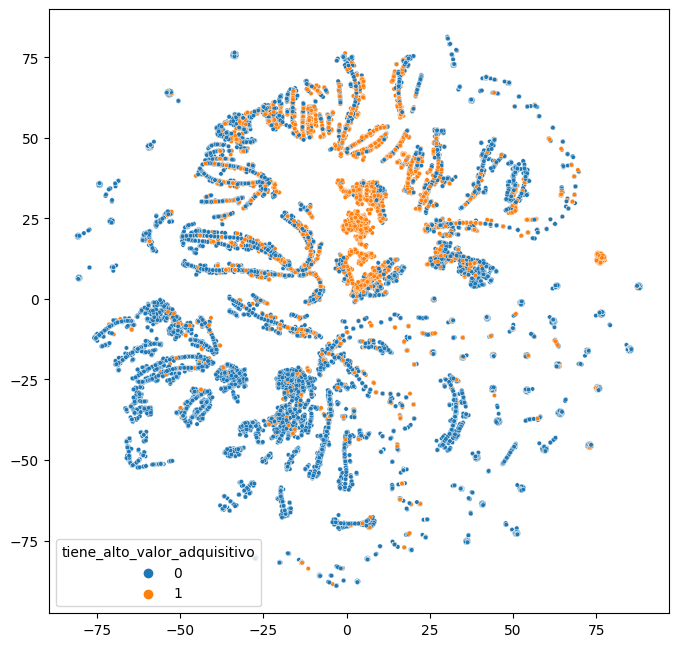

In [11]:
fig = plt.figure(figsize=(8,8), dpi=100)
sns.scatterplot(
    x = X_tsne_1[:,0],
    y = X_tsne_1[:,1],
    hue = Y,
    s=10
)

plt.show()

Vemos que a priori (con la aproximación de tSNE) parece haber una separación en los datos, los azules (ceros) tienden a ir más hacia los límites inferiores y laterales  mientras que los naranjas (unos) tienden a estar cerca del centro y el límite superior.

De todas maneras se puede ver que los puntos azules también se encuentran en la posición de los naranjas (aunque con menos densidad relativa a los puntos azules (que son la clase mayoritaria) pero con denisdad cercana a la naranja)

Además la cantidad de features utilizados es de 4. Veamos si agregando más features se logra obtener algo diferente.

Es por esto que seguiremos buscando

### 2) Las primeras variables continuas utilizadas en un árbol de decisión

La idea es ver con el árbol de decisión aquellas variables continuas que mejor "dividen" el espacio para predecir, por ende usaremos un árbol para ver qué nodos tomó en cada nivel.

In [12]:
from sklearn.tree import DecisionTreeClassifier

import graphviz
import dtreeviz.trees as dtreeviz

In [14]:
arbol = DecisionTreeClassifier(criterion='gini', max_depth=3)
arbol.fit(X, Y)

DecisionTreeClassifier(max_depth=3)

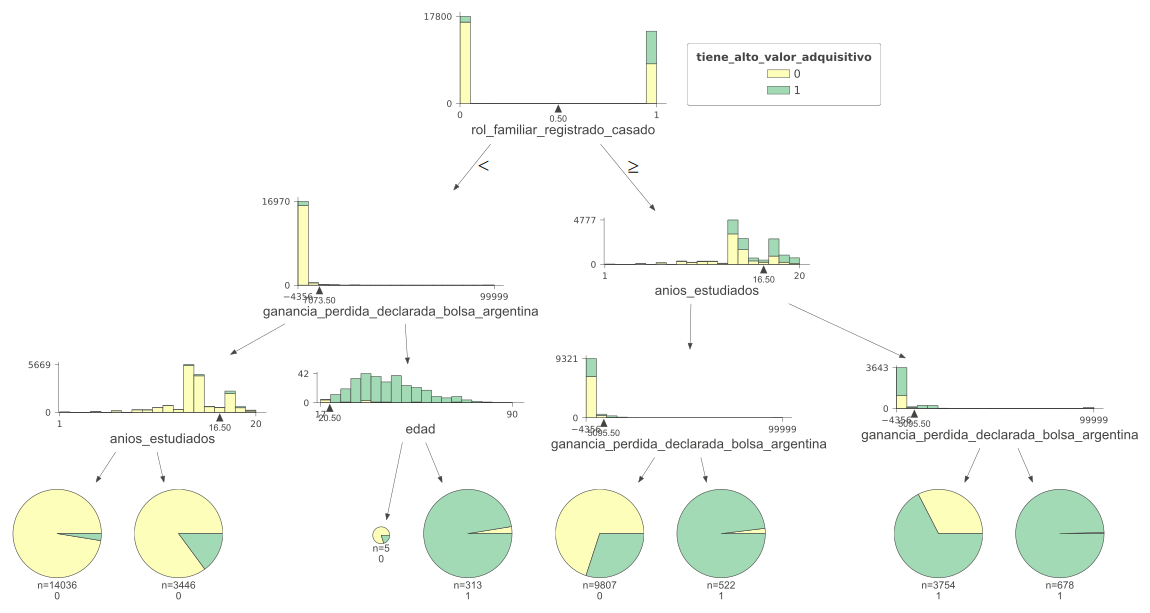

In [16]:
viz = dtreeviz.dtreeviz(
    arbol,
    X,
    Y,
    target_name='tiene_alto_valor_adquisitivo',
    feature_names=list(X.columns),
    class_names=list([0,1]),
    scale=1.5,
)

display(viz)

Se ve aquí que efectivamente se utilizan las siguientes 3 variables (continuas):
 * Edad
 * Ganancia/Pérdida declarada en la bolsa argentina
 * Años estudiados
Lo que quiere decir que, las horas trabajadas "no dividen muy bien" al espacio según el árbol de decisión.

In [18]:
def dejar_mejores_variables_continuas(X):
    return X[['anios_estudiados', 'ganancia_perdida_declarada_bolsa_argentina',
              'edad']].copy()

scaler2 = StandardScaler()
X_2 = pd.DataFrame(scaler2.fit_transform(dejar_mejores_variables_continuas(X)))

Veamos si TSNE nos muestra algo interesante:

In [19]:
X_tsne_2 = TSNE(n_components=2, perplexity=200, learning_rate=100, n_iter_without_progress=250, n_jobs=-1, verbose=4).fit_transform(X_2)

[t-SNE] Computing 601 nearest neighbors...
[t-SNE] Indexed 32561 samples in 0.536s...
[t-SNE] Computed neighbors for 32561 samples in 4.876s...
[t-SNE] Computed conditional probabilities for sample 1000 / 32561
[t-SNE] Computed conditional probabilities for sample 2000 / 32561
[t-SNE] Computed conditional probabilities for sample 3000 / 32561
[t-SNE] Computed conditional probabilities for sample 4000 / 32561
[t-SNE] Computed conditional probabilities for sample 5000 / 32561
[t-SNE] Computed conditional probabilities for sample 6000 / 32561
[t-SNE] Computed conditional probabilities for sample 7000 / 32561
[t-SNE] Computed conditional probabilities for sample 8000 / 32561
[t-SNE] Computed conditional probabilities for sample 9000 / 32561
[t-SNE] Computed conditional probabilities for sample 10000 / 32561
[t-SNE] Computed conditional probabilities for sample 11000 / 32561
[t-SNE] Computed conditional probabilities for sample 12000 / 32561
[t-SNE] Computed conditional probabilities for sa

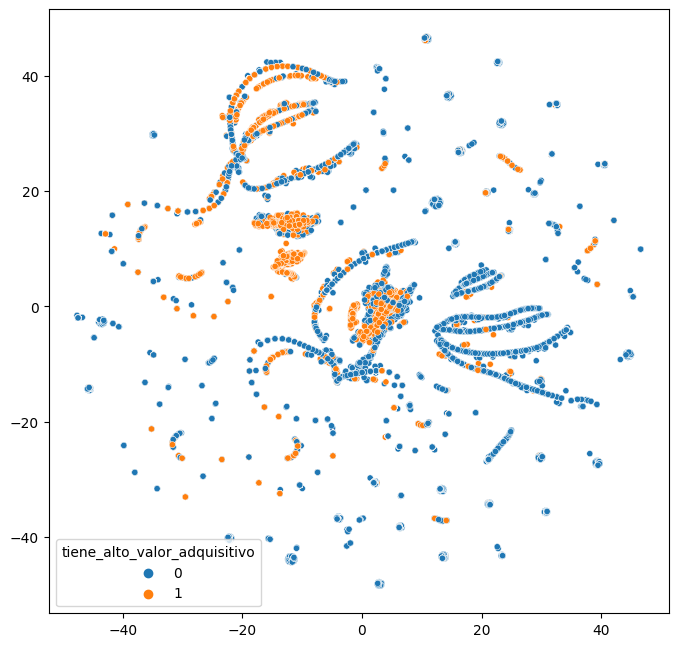

In [22]:
fig = plt.figure(figsize=(8,8), dpi=100)
sns.scatterplot(
    x = X_tsne_2[:,0],
    y = X_tsne_2[:,1],
    hue = Y,
    s=20
)

plt.show()

Vemos que empeoró bastante (probablemente por el approach de tSNE) pero no parece ser para nada una buena selección de variables para utilizar los modelos de KNN o SVM.

Hay que seguir buscando.

### 3) Las primeras variables (no sólo continuas) que elije un árbol de decisión de altura 3. 

Veamos ahora las primeras variables que no son únicamente continuas que elije un árbol de decisión para separar el espacio, para ello tendremos que realizar un árbol de decisión de altura 3.

In [24]:
arbol = DecisionTreeClassifier(criterion='gini', max_depth=3)
arbol.fit(X, Y)

DecisionTreeClassifier(max_depth=3)

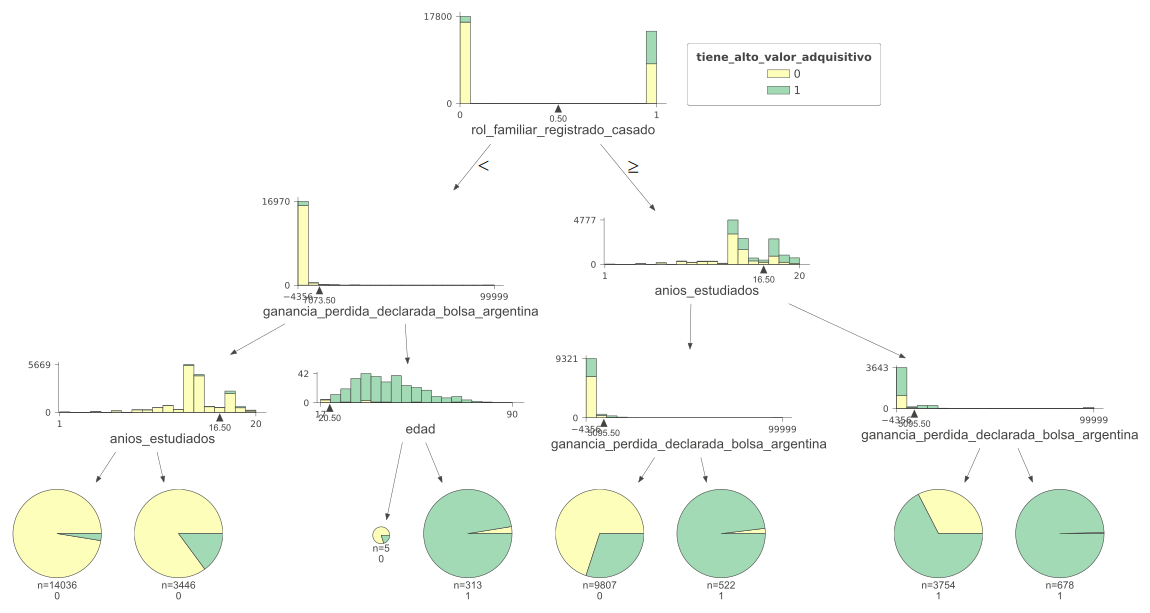

In [26]:
viz = dtreeviz.dtreeviz(
    arbol,
    X,
    Y,
    target_name='tiene_alto_valor_adquisitivo',
    feature_names=list(X.columns),
    class_names=list([0,1]),
    scale=1.5,
)

display(viz)

Vemos de este árbol que las variables elegidas fueron:

* Rol familiar registrado casado
* Ganancia/Pérdida declarada en la bolsa argentina.
* Años estudiados.
* Edad

Por lo que sólo se agregó una variable (dummy) a las 3 previamente seleccionadas.

Además cabe mencionar que la nueva variables incluida es la raíz del árbol, eso quiere decir que de todas las raíces posibles, la que mejor índice de Gini obtenía es la variable de casado.

Veamos qué ocurre!


In [27]:
def primeras_4_del_arbol(X):
    return X[['anios_estudiados', 'ganancia_perdida_declarada_bolsa_argentina',
              'edad', 'rol_familiar_registrado_casado']].copy()

scaler3 = StandardScaler()

X_3 = pd.DataFrame(scaler3.fit_transform(primeras_4_del_arbol(X)))

Veamos qué hace tSNE con esta nueva selección de variables.

In [28]:
X_tsne_3 = TSNE(n_components=2, perplexity=100, learning_rate=100, n_iter_without_progress=250, n_jobs=-1, verbose=4).fit_transform(X_3)

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 32561 samples in 0.579s...
[t-SNE] Computed neighbors for 32561 samples in 2.308s...
[t-SNE] Computed conditional probabilities for sample 1000 / 32561
[t-SNE] Computed conditional probabilities for sample 2000 / 32561
[t-SNE] Computed conditional probabilities for sample 3000 / 32561
[t-SNE] Computed conditional probabilities for sample 4000 / 32561
[t-SNE] Computed conditional probabilities for sample 5000 / 32561
[t-SNE] Computed conditional probabilities for sample 6000 / 32561
[t-SNE] Computed conditional probabilities for sample 7000 / 32561
[t-SNE] Computed conditional probabilities for sample 8000 / 32561
[t-SNE] Computed conditional probabilities for sample 9000 / 32561
[t-SNE] Computed conditional probabilities for sample 10000 / 32561
[t-SNE] Computed conditional probabilities for sample 11000 / 32561
[t-SNE] Computed conditional probabilities for sample 12000 / 32561
[t-SNE] Computed conditional probabilities for sa

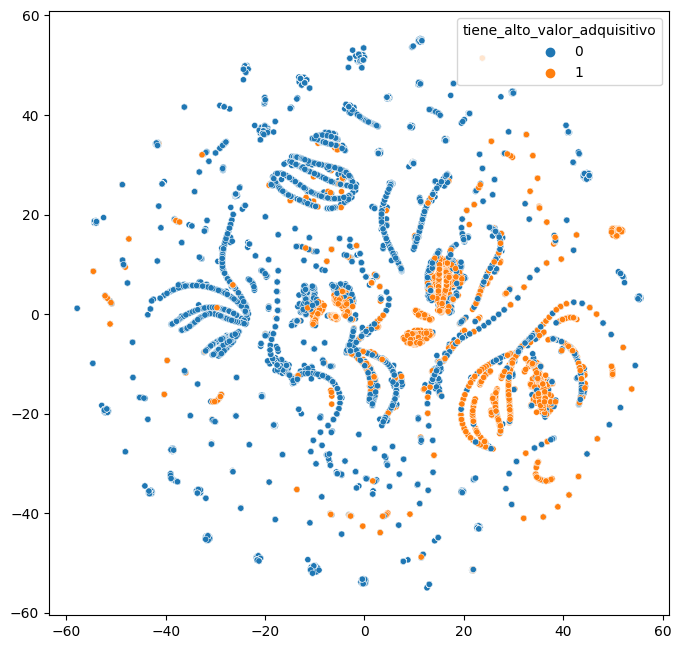

In [30]:
fig = plt.figure(figsize=(8,8), dpi=100)
sns.scatterplot(
    x = X_tsne_3[:,0],
    y = X_tsne_3[:,1],
    hue = Y,
    s=20
)

plt.show()

Similar a los análisis anteriores, no parece haber un patrón claro ni para KNN ni para SVM, creemos que esto es en parte debido a la poca cantidad de features que estamos utilizando, veamos si agregamos algunas más si mejora la cosa.

### 4) Un rejunte final

Veamos sin tener en cuenta las variables previamente utilizadas con qué variables se queda un árbol de decisión.

In [32]:
arbol = DecisionTreeClassifier(criterion='gini', max_depth=3)
arbol.fit(X[X.columns.drop(['anios_estudiados', 'ganancia_perdida_declarada_bolsa_argentina', 'edad', 'rol_familiar_registrado_casado'])], Y)

DecisionTreeClassifier(max_depth=3)

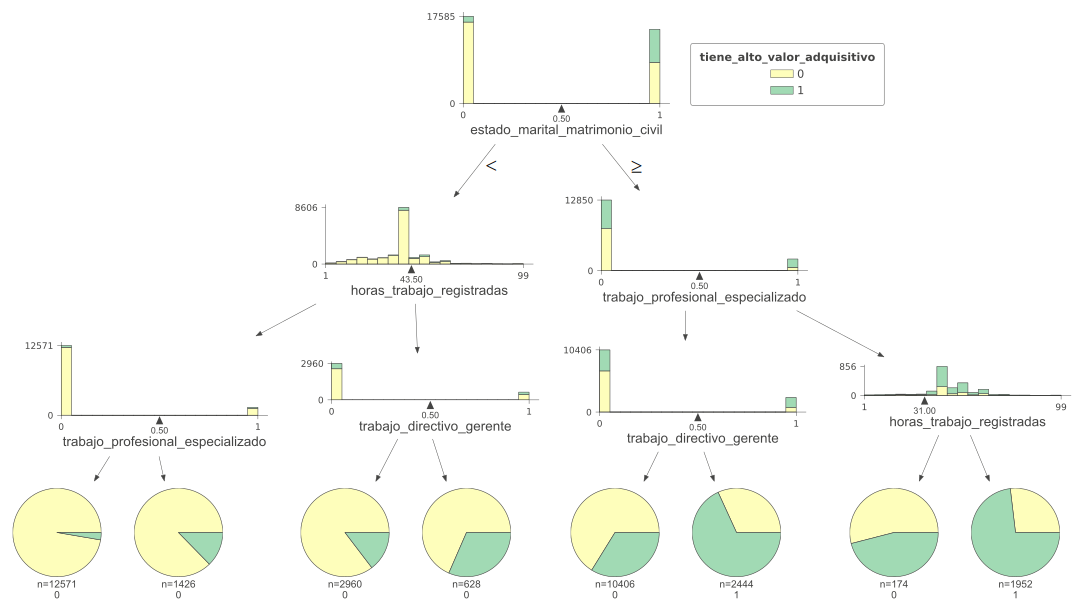

In [33]:
viz = dtreeviz.dtreeviz(
    arbol,
    X[X.columns.drop(['anios_estudiados', 'ganancia_perdida_declarada_bolsa_argentina', 'edad', 'rol_familiar_registrado_casado'])],
    Y,
    target_name='tiene_alto_valor_adquisitivo',
    feature_names=list(X.columns.drop(['anios_estudiados', 'ganancia_perdida_declarada_bolsa_argentina', 'edad', 'rol_familiar_registrado_casado'])),
    class_names=list([0,1]),
    scale=1.5,
)

display(viz)

##### Variables que nos vamos a quedar.

* Estado marital: matrimonio civil
* Horas de trabajo registradas
* Trabajo: profesional especializado
* Trabajo: directivo gerente


Vemos por ejemplo que ahora sí se tuvo en cuenta (y relativamente temprano a las horas de trabajas registradas)

Por lo que, ahora las features que utilizaremos serán las utilizadas previamente junto a estas nuevas.

In [34]:
def mejores_por_arbol(X):
    eleccion = ['estado_marital_matrimonio_civil', 'horas_trabajo_registradas',
                'trabajo_profesional_especializado', 'trabajo_directivo_gerente',
                'anios_estudiados', 'ganancia_perdida_declarada_bolsa_argentina',
                'edad', 'rol_familiar_registrado_casado']
    return X[eleccion].copy()

X_4 = pd.DataFrame(mejores_por_arbol(X))

In [49]:
X_tsne_4 = TSNE(n_components=2, perplexity=40, learning_rate=400, n_iter_without_progress=250, n_jobs=-1, verbose=4).fit_transform(X_4)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 32561 samples in 0.682s...
[t-SNE] Computed neighbors for 32561 samples in 1.747s...
[t-SNE] Computed conditional probabilities for sample 1000 / 32561
[t-SNE] Computed conditional probabilities for sample 2000 / 32561
[t-SNE] Computed conditional probabilities for sample 3000 / 32561
[t-SNE] Computed conditional probabilities for sample 4000 / 32561
[t-SNE] Computed conditional probabilities for sample 5000 / 32561
[t-SNE] Computed conditional probabilities for sample 6000 / 32561
[t-SNE] Computed conditional probabilities for sample 7000 / 32561
[t-SNE] Computed conditional probabilities for sample 8000 / 32561
[t-SNE] Computed conditional probabilities for sample 9000 / 32561
[t-SNE] Computed conditional probabilities for sample 10000 / 32561
[t-SNE] Computed conditional probabilities for sample 11000 / 32561
[t-SNE] Computed conditional probabilities for sample 12000 / 32561
[t-SNE] Computed conditional probabilities for sa

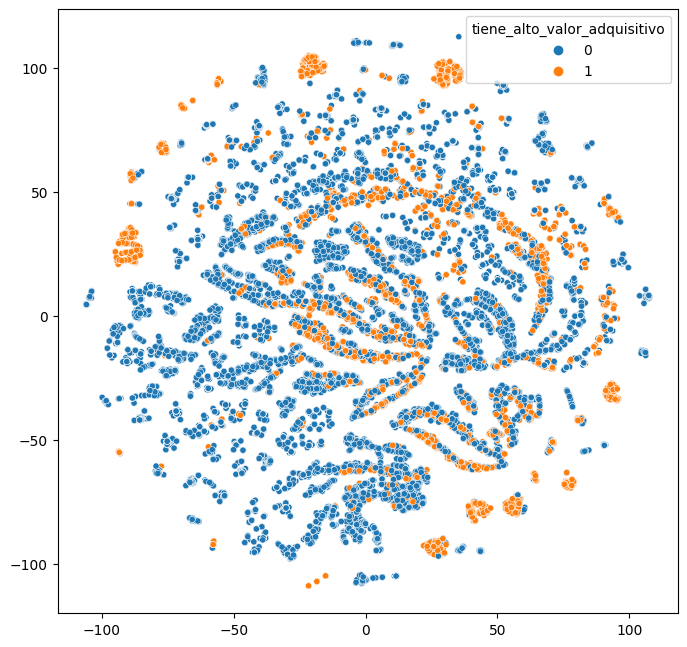

In [51]:
fig = plt.figure(figsize=(8,8), dpi=100)
sns.scatterplot(
    x = X_tsne_4[:,0],
    y = X_tsne_4[:,1],
    hue = Y,
    s=20
)

plt.show()

Vemos aquí que no parece haber un patrón distinguible para las instancias.

Creemos que KNN hará un buen trabajo ya que las instancias parecen estar bastante juntas y se generan algunos pequeños clusters de un color particular.

Sin embargo es probable que a SVM le cueste mucho más, ya que a priori no parece que los datos sean separables.

##### Nota:
Utilizamos dicho preprocessing y a SVM le dio buen resultado (mucho mejor resultado que con el primer preprocessing propuesto en este notebook)
Probablemente esto se deba a una mala interpretación de el gráfico que nos da tSNE o mismamente de este método.